<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

In [32]:
import pandas as pd
df = pd.read_csv('./data/job_listings.csv', index_col=0)
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [33]:
df.shape

(426, 2)

In [68]:
df.at[0, 'description']

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [153]:
from bs4 import BeautifulSoup
import requests
import re

def clean_description(desc):
    soup_text = BeautifulSoup(desc[2:-1]).get_text()  # remove b"..." from the ends
    soup_text = re.sub('\\\\n', ' ', soup_text)  # replace new line characters with whitespace
    soup_text = re.sub('\\\\x..', '', soup_text)  # remove unrecognized unicode hex characters
    return soup_text.lower()  # make sure case doesn't matter

df['clean_desc'] = df['description'].apply(clean_description)

In [154]:
df.at[0, 'clean_desc']

"job requirements: conceptual understanding in machine learning models like naive bayes, k-means, svm, apriori, linear/ logistic regression, neural, random forests, decision trees, k-nn along with hands-on experience in at least 2 of them intermediate to expert level coding skills in python/r. (ability to write functions, clean and efficient data manipulation are mandatory for this role) exposure to packages like numpy, scipy, pandas, matplotlib etc in python or ggplot2, dplyr, tidyr in r ability to communicate model findings to both technical and non-technical stake holders hands on experience in sql/hive or similar programming language must show past work via github, kaggle or any other published article master's degree in statistics/mathematics/computer science or any other quant specific field. apply now"

## 2) Use Spacy to tokenize the listings 

In [156]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

def get_tokens(doc_array):
    tokens = []
    for doc in tokenizer.pipe(doc_array, batch_size=500):
        tokens.append([token.text for token in doc])
    return tokens

In [157]:
df['desc_tokens'] = get_tokens(df['clean_desc'])
df.at[0, 'desc_tokens'][:15]

['job',
 'requirements:',
 'conceptual',
 'understanding',
 'in',
 'machine',
 'learning',
 'models',
 'like',
 'naive',
 'bayes,',
 'k-means,',
 'svm,',
 'apriori,',
 'linear/']

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [158]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['clean_desc'])

word_counts = vectorizer.transform(df['clean_desc'])
word_counts = pd.DataFrame(word_counts.todense(), columns=vectorizer.get_feature_names())

In [159]:
word_counts.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zf,zfs,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [160]:
# counts all occurences of each word
word_counts.sum().sort_values(ascending=False)

and            11754
to              6942
the             5550
of              4614
data            4466
               ...  
orchestra          1
orchestrate        1
designpac          1
orcle              1
zurichs            1
Length: 8786, dtype: int64

In [161]:
import squarify
import matplotlib.pyplot as plt

def visualize_common_words(word_counts, num_words=20, remove_stops=True):
    """ Takes a dataframe of word counts and visualizes the most common words """
    
    # get a descending list of the most common words
    totals = word_counts.sum().sort_values(ascending=False)
    word_count = totals.sum()
    
    top_words = [[],[]]
    if(remove_stops):
        for i in range(len(totals)):
            # check if each word is a stop word before adding it
            if (totals.index[i] not in nlp.Defaults.stop_words):
                # append word and normalized count
                top_words[0].append(totals.index[i])
                top_words[1].append(totals[i]/word_count)
                
            # break loop once enough words have been found
            if len(top_words[0]) >= num_words:
                break
    else:
        # no need to remove any, just take a slice
        top_words[0] = totals.index[:num_words]
        top_words[1] = totals.values[:num_words]
    
    squarify.plot(sizes=top_words[1], label=top_words[0], alpha=.8)
    plt.axis('off')
    plt.show()

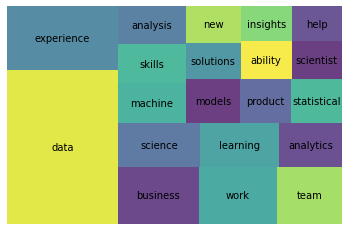

In [162]:
visualize_common_words(word_counts)

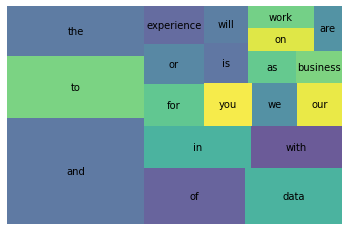

In [163]:
visualize_common_words(word_counts, remove_stops=False)

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english")
vectorizer.fit(df['clean_desc'])

tf_idf = vectorizer.transform(df['clean_desc'])
tf_idf = pd.DataFrame(tf_idf.todense(), columns=vectorizer.get_feature_names())

In [165]:
tf_idf.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zf,zfs,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.106247,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [118]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(tf_idf)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [125]:
my_listing = "I want to use Neural Networks to create new things"
nn.kneighbors(vectorizer.transform([my_listing]).todense())

(array([[1.32120096, 1.32786079, 1.33330708, 1.33887997, 1.33887997]]),
 array([[ 89, 346, 399,  77, 214]], dtype=int64))

In [126]:
df.at[89, 'clean_desc']

"About Uber Were changing the way people think about transportation. Not that long ago we were just an app to request premium black cars in a few metropolitan areas. Now were a part of the logistical fabric of more than 600 cities around the world. Whether its a ride, a sandwich, or a package, we use technology to give people what they want, when they want it.  For the people who drive with Uber, our app represents a flexible new way to earn money. For cities, we help strengthen local economies, improve access to transportation, and make streets safer.  And thats just what were doing today. Were thinking about the future, too. With teams working on autonomous trucking and self-driving cars, were in for the long haul. Were reimagining how people and things move from one place to the next. About the Role  We are looking for data scientists with strong backgrounds in statistics, machine learning, computer science, etc to join the core product team at Uber. In this role, you will embed in 

In [189]:
def show_similar_listings(listing, max_length=None):
    """
    Prints the 5 most similar job listings to the given listing
    
    If max_length is specified, it will print that many characters of each listing
    """
    
    listing = listing.lower()
    transformed_listing = vectorizer.transform([listing]).todense()
    results = nn.kneighbors(transformed_listing)
    strengths = results[0][0]
    similar_listings = results[1][0]
    
    for i in range(5):
        print(f"Listing {similar_listings[i]}, Title: {df.at[similar_listings[i], 'title']}, Similarity: {strengths[i]}")
        if max_length is None:
            print(df.at[similar_listings[i], 'clean_desc'], '\n')
        else:
            text = df.at[similar_listings[i], 'clean_desc']
            if len(text) > max_length:
                print(df.at[similar_listings[i], 'clean_desc'][:max_length] + '...', '\n')
            else:
                print(df.at[similar_listings[i], 'clean_desc'], '\n')

In [190]:
new_listing = "generative generate machine learning ai"
show_similar_listings(new_listing, max_length=2000)

Listing 90, Title: Data Scientist (Multiple levels), Similarity: 1.331947960290444
data scientist (multiple levels)-19000c1k   no visa sponsorship is available for this position.  preferred qualifications  preferred qualifications  within the ai apps team at oracle we develop and deploy data science solutions at scale and throughout all of oracle's existing products and services, and are seeking to grow the team with brilliant and diverse individuals with well-crafted technical ability. this is an exciting and challenging role that will stretch your knowledge and curiosity, offering the opportunity to learn new skills and work within an unusually talented, global community at oracle.   you will encounter a wide variety of data types, from retail and financial transactions to free text, images and video. ai apps are required to solve business challenges ranging from recommendation systems and dynamic discounting, management of the flow of goods and services, transportation logistics and

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 